# BISMILLAH

## 1. Importing Libraries and Preparing Dataset


In [85]:

# Importing all the relevant libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision
import torchvision.transforms as tr
REBUILD_DATA=True # because we dont want to build data everytime running the code
from torch.utils.data import TensorDataset
from torch.utils.data import TensorDataset, DataLoader,Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

import skimage
import skimage.io as io
from matplotlib import cm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Switich to the correct directory
cd C:\Users\22534935\OneDrive - MMU\Deep Learning\data\TrainingSet

SyntaxError: invalid syntax (2241597858.py, line 2)

In [79]:
len(dataset)


5936

In [7]:
# Changing the name of the files
folder_path = "Closed"
word_to_add = "close."  # Change this to the word you want to add

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        new_filename = word_to_add + filename
        os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

In [34]:
#making a list and labeling it
o=[]
c=[]
for x in os.listdir('open_and_close'):
    if x.startswith('op'):
        o.append(x)
    if x.startswith('cl'):
        c.append(x)

o=[(x,1) for x in o]
c=[(x,0)for x in c]
o_c=o+c
# converting the list to a pandas df and saving it as csv
df=np.array(o_c)
df=pd.DataFrame(df)
file='open_and_close.csv'
df.to_csv(file,header=False,index=False)

In [35]:
#Loading an example for visualisation

df = pd.read_csv('open_and_close.csv')


n = 5000
img_name = df.iloc[n, 0]
y_label = df.iloc[n, 1:]
y_label = np.asarray(y_label, dtype=float).reshape(-1, 1)

#checking if any image is not an nmpy array

#broken_image=[]
#for x in range(len(df)):    
#    img_name = df.iloc[x, 0]
#    image = cv2.imread(os.path.join('open_and_close/', img_name))
    
#    if not isinstance(image, np.ndarray):
#        print(img_name)
        

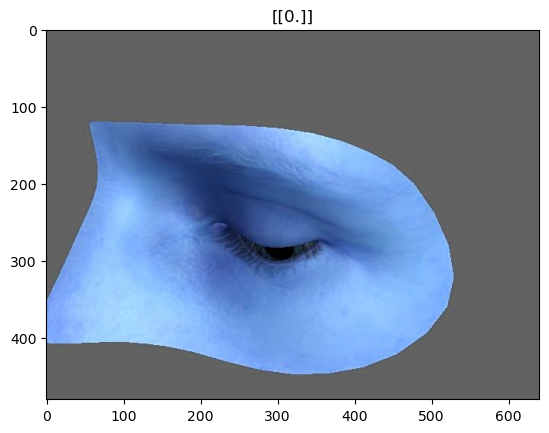

In [36]:
#Visualising an image
def show(image,y_label):
    plt.imshow(image)
    plt.title(str(y_label))
plt.figure()
show(cv2.imread(os.path.join('open_and_close/',img_name)),y_label)
plt.show()

## 2. Creating a Custom Data Object and Appying Transformations

In [321]:
# Making an object to prepare the data

class OpenAndClose(Dataset):
    
    # This is the constructor with attributes
    def __init__(self, csv_file, root_dir, transform=None):
        
        self.y_label_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.y_label_frame)

    def __getitem__(self, idx): #when calling this metthod, index will be taken as an input
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.y_label_frame.iloc[idx, 0])
        
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        
        
        
        y_label = self.y_label_frame.iloc[idx, 1:]
        y_label = np.array([y_label], dtype=float).reshape(-1, 1) # this depends on the shape of y data we have
        sample = {'image': image, 'y': y_label}
        image=sample['image']
        y_label=sample['y']
        
        
        
        y_label = torch.tensor(int(self.y_label_frame.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)
        #image=image.permute(2, 0, 1)
        
        #if image.shape[0]>3:
        #    print('error')
        #    print(img_name)
            
      

        
        return image,y_label

In [39]:
# Calculating the mean and std for normalisation
dataset=OpenAndClose(csv_file='open_and_close.csv',root_dir='open_and_close/')
# Define transformations
trans = tr.Compose([
    tr.ToTensor()
])

# Initialize variables to accumulate mean and std
mean_sum = 0.0
std_sum = 0.0
num_images = len(dataset)
count=0

# Iterate through the dataset to calculate mean and std
for i in range(num_images):
    try:
        image = dataset[i][0]  # Get the i-th image from the dataset
        img_tr = trans(image)  # Apply the transformation to the image
        mean_sum += img_tr.mean([1, 2])
        std_sum += img_tr.std([1, 2])
        count+=1
    except:
        pass

# Calculate the mean and std across all images
overall_mean = mean_sum / num_images
overall_std = std_sum / num_images

print(f"Overall Mean: {overall_mean}")
print(f"Overall Std: {overall_std}")

Overall Mean: tensor([0.3913, 0.4317, 0.4939])
Overall Std: tensor([0.1009, 0.1224, 0.1797])


In [322]:
# Making a custom transformner to transform imgaes
custom_transform = tr.Compose([
    tr.ToPILImage(),    
    tr.Resize((200, 200)),      # Resize the image
    #tr.ColorJitter(brightness=0.5),
    tr.RandomRotation(degrees=45),
        
    tr.RandomVerticalFlip(p=0.02),
    tr.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally (data augmentation)
    tr.ToTensor(),              # Convert the image to a PyTorch tensor
    #tr.Normalize(mean=overall_mean,std=overall_std)
    
    
])

In [323]:
# Applying the transformations to data
dataset=OpenAndClose(csv_file='open_and_close.csv',root_dir='open_and_close/',transform=custom_transform)

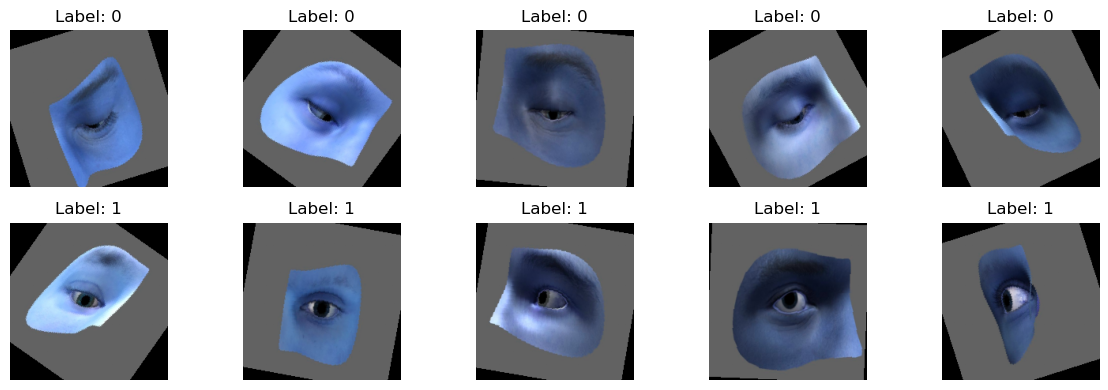

In [324]:

# Create a new figure
fig = plt.figure(figsize=(12, 4))  # Adjust the figsize as needed

# Define the number of columns for subplots
num_columns = 5  # Adjust the number of columns as needed

# Filter the dataset to get examples with label 0 and label 1
label_0_examples = [example for example in dataset if example[1] == 0]
label_1_examples = [example for example in dataset if example[1] == 1]

# Loop through and display examples for label 0
for i, (image, label) in enumerate(label_0_examples):
    if i >= num_columns:
        break
    
    # Create a subplot
    ax = fig.add_subplot(2, num_columns, i + 1)
    
    # Set the subplot title (use label 0 as the title)
    ax.set_title("Label: 0")
    
    # Turn off the axis labels (if desired)
    ax.axis('off')
    
    # Display the image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

# Loop through and display examples for label 1
for i, (image, label) in enumerate(label_1_examples):
    if i >= num_columns:
        break
    
    # Create a subplot
    ax = fig.add_subplot(2, num_columns, num_columns + i + 1)
    
    # Set the subplot title (use label 1 as the title)
    ax.set_title("Label: 1")
    
    # Turn off the axis labels (if desired)
    ax.axis('off')
    
    # Display the image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [80]:
#making the train and test set
train_set,test_set=torch.utils.data.random_split(dataset,[5000,936])

#loading the data using the utility
train_loader=DataLoader(dataset=train_set,batch_size=8,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=8,shuffle=True)

In [77]:
print(f'{float(len(label_0_examples)/len(dataset)*100)}% of the data is for Closed/drowsy eye images')
print(f'{float(len(label_1_examples)/len(dataset)*100)}% of the data is for Closed/drowsy eye images')

51.71832884097035% of the data is for Closed/drowsy eye images
48.28167115902965% of the data is for Closed/drowsy eye images


## 3. Developing a Base CNN Model

In [145]:
num_epochs=10
batch_size=8
learning_rate=0.004
# it is also a good idea to to set up the gpu
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [146]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #layers
        
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        
        #fully connected layer
        self.fc1=nn.Linear(16*47*47,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,2)
        
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*47*47)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
            
        return x
        
        
model=ConvNet().to(device)
    
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
    
            
            
            
        
        
        

In [156]:
# now we can set up a loop to run the model and learn the params in the defined epochs
import time

start_time=time.time()

total_steps=(len(train_loader))

for epoch in range(20):
    
    lossess=[]
    list_losses=[]
    for i,(images, labels) in tqdm(enumerate (train_loader)):
        
        #pushing the data to GPU
        images=images.to(device)
        labels=labels.to(device)
        
        #Forward Propogation
        outputs=model(images)
        loss=criterion(outputs,labels)
        
        lossess.append(loss.item())
        
        #Backward Propogation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
            
    list_losses.append(sum(lossess)/len(lossess))    
    print(f'Cost at epoch {epoch} is {sum(lossess)/len(lossess)}')
            
end_time=time.time()                       
print('Training Finished')

print(f'Completed in {end_time-start_time} seconds')





                   

625it [00:35, 17.38it/s]


Cost at epoch 0 is 0.1397272168653086


625it [00:35, 17.39it/s]


Cost at epoch 1 is 0.14056220729779453


625it [00:34, 18.03it/s]


Cost at epoch 2 is 0.1447168979588896


625it [00:36, 16.91it/s]


Cost at epoch 3 is 0.14037340150885283


625it [00:36, 17.06it/s]


Cost at epoch 4 is 0.13664979186458512


625it [00:35, 17.42it/s]


Cost at epoch 5 is 0.1325889736992307


625it [00:35, 17.42it/s]


Cost at epoch 6 is 0.13672862148657441


625it [00:36, 17.31it/s]


Cost at epoch 7 is 0.13242761560622604


625it [00:36, 17.15it/s]


Cost at epoch 8 is 0.12507268547154962


625it [00:36, 17.21it/s]


Cost at epoch 9 is 0.12635725915282964


625it [00:35, 17.38it/s]


Cost at epoch 10 is 0.12382215791298076


625it [00:36, 17.19it/s]


Cost at epoch 11 is 0.12350481842625886


625it [00:35, 17.53it/s]


Cost at epoch 12 is 0.12807778417747467


625it [00:36, 17.10it/s]


Cost at epoch 13 is 0.11606839689780027


625it [00:36, 17.28it/s]


Cost at epoch 14 is 0.12064929108815267


625it [00:36, 17.01it/s]


Cost at epoch 15 is 0.12160184475835413


625it [00:36, 17.22it/s]


Cost at epoch 16 is 0.11733020137762651


625it [00:35, 17.45it/s]


Cost at epoch 17 is 0.11293253581887111


625it [00:35, 17.52it/s]


Cost at epoch 18 is 0.11922188289240003


625it [00:35, 17.60it/s]

Cost at epoch 19 is 0.11728157126680017
Training Finished
Completed in 721.581832408905 seconds


In [158]:
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [150]:
def check_accuracy(loader,model):
    n_correct = 0
    n_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device)
            y=y.to(device)
            
            scores=model(x)
            _,predictions=scores.max(1)
            n_correct+=(predictions==y).sum()
            n_samples+=predictions.size(0)
            
        print(f'Got {n_correct} /{n_samples} correct with accuracy {float(n_correct)/float(n_samples)*100}%')
    model.train()

print('For Training')
check_accuracy(train_loader,model)

print('For test')
check_accuracy(test_loader,model)

For Training
Got 4748 /5000 correct with accuracy 94.96%
For test
Got 882 /936 correct with accuracy 94.23076923076923%


In [155]:
len(lossess)

625

In [153]:
sum(lossess)/len(lossess)

0.14857784945107996

In [316]:
ol_list=[]
cl_list=[]

r=['/Users/22534935/OneDrive - MMU/Deep Learning/data/archive/train/Closed/',
  '/Users/22534935/OneDrive - MMU/Deep Learning/data/archive/train/Open/']

for x in r:
    for y in os.listdir(x)[:4]:
        file_path=os.path.join(x,y)
        image=cv2.imread(file_path,cv2.COLOR_BGR2RGB)[:,:,::-1]
        if 'Open' in x:
            ol_list.append(image)
        elif 'Closed' in x:
            cl_list.append(image)
            

test_list=ol_list+cl_list

In [317]:
len(test_list)

8

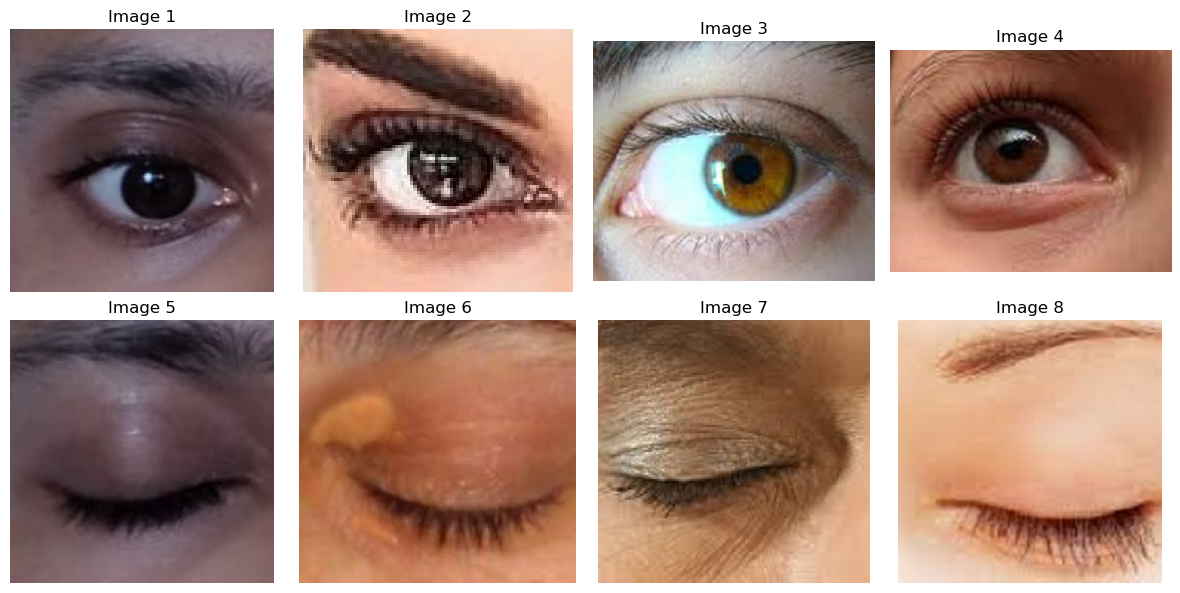

In [414]:
col=4
row=2
fig,axes=plt.subplots(row,col,figsize=(12,6))
axes=axes.ravel()

for i in range(len(test_list)):
    ax=axes[i]
    ax.imshow(test_list[i])
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()


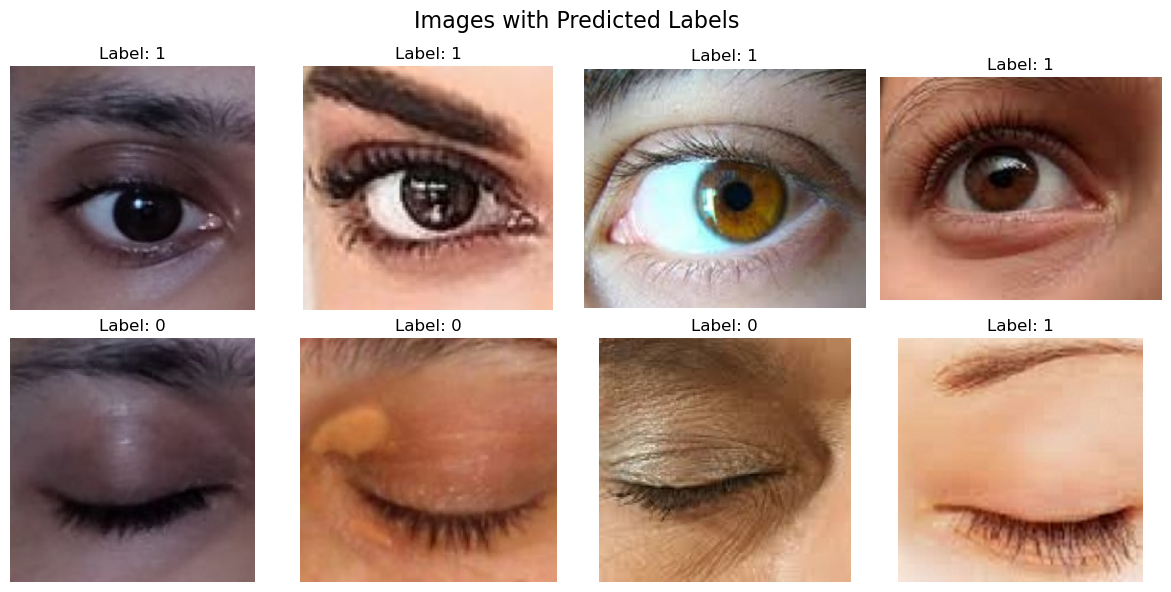

In [420]:

pr=[]
for i,image in enumerate(test_list):  
    

    image=custom_transform(image)

    image=image.unsqueeze(0)
    image=image.to(device)
    output=model(image)
    pred=torch.argmax(output)
    pr.append(pred.item())

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Images with Predicted Labels", fontsize=16)



# Flatten the axes array to iterate through subplots
axes = axes.ravel()

# Iterate through the image-label pairs and display them in subplots
for i in range(len(test_list)):
    ax = axes[i]
    ax.imshow(test_list[i])  # Display the image
    ax.set_title(f"Label: {pr[i]}")  # Set the title as the label
    ax.axis("off")  # Turn off axis labels

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

In [417]:
pr=[]
for i,image in enumerate(test_list):  
    

    image=custom_transform(image)

    image=image.unsqueeze(0)
    image=image.to(device)
    output=model(image)
    pred=torch.argmax(output)
    pr.append(pred.item())
    


In [416]:
ll

[array([[[ 80,  65,  70],
         [ 85,  70,  75],
         [ 91,  75,  78],
         ...,
         [142, 121, 126],
         [145, 124, 129],
         [145, 124, 129]],
 
        [[ 85,  70,  75],
         [ 89,  74,  79],
         [ 93,  77,  80],
         ...,
         [143, 122, 129],
         [145, 124, 129],
         [145, 124, 129]],
 
        [[ 89,  72,  78],
         [ 91,  74,  80],
         [ 95,  76,  80],
         ...,
         [144, 123, 130],
         [145, 124, 131],
         [144, 123, 130]],
 
        ...,
 
        [[119,  97, 100],
         [119,  97, 100],
         [122,  97, 101],
         ...,
         [130,  96,  95],
         [130,  96,  95],
         [130,  96,  95]],
 
        [[121,  99, 102],
         [120,  98, 101],
         [123,  98, 102],
         ...,
         [130,  96,  95],
         [130,  96,  95],
         [130,  96,  95]],
 
        [[122, 100, 103],
         [122, 100, 103],
         [124,  99, 103],
         ...,
         [130,  96,  95],
  

IndexError: index 1 is out of bounds for dimension 0 with size 0

In [349]:
pred=torch.argmax(output)
pred

tensor(1, device='cuda:0')

In [315]:
image

tensor([[[[-0.7479, -0.6965, -0.6109,  ...,  0.3481,  0.3652,  0.3652],
          [-0.6965, -0.6452, -0.5767,  ...,  0.3481,  0.3652,  0.3652],
          [-0.6281, -0.5938, -0.5424,  ...,  0.3481,  0.3652,  0.3652],
          ...,
          [-0.0629, -0.0629, -0.0458,  ...,  0.1083,  0.1083,  0.1083],
          [-0.0458, -0.0458, -0.0287,  ...,  0.1083,  0.1083,  0.1083],
          [-0.0287, -0.0287, -0.0116,  ...,  0.1083,  0.1083,  0.1083]],

         [[-0.8978, -0.8452, -0.7752,  ...,  0.1176,  0.1352,  0.1352],
          [-0.8452, -0.7927, -0.7402,  ...,  0.1176,  0.1352,  0.1352],
          [-0.7927, -0.7577, -0.7227,  ...,  0.1176,  0.1352,  0.1352],
          ...,
          [-0.3200, -0.3200, -0.3200,  ..., -0.3550, -0.3550, -0.3550],
          [-0.3025, -0.3025, -0.3025,  ..., -0.3550, -0.3550, -0.3550],
          [-0.2850, -0.2850, -0.2850,  ..., -0.3550, -0.3550, -0.3550]],

         [[-0.5844, -0.5321, -0.4798,  ...,  0.4265,  0.4439,  0.4439],
          [-0.5321, -0.4798, -